## q<sup>2</sup> Tutorial - 6. Stellar parameters from isochrones

Fundamental stellar parameters like mass, age, luminosity, and radius are difficult to derive from basic principles. For many stars, however, theoretical isochrones can be used to constrain these parameters. The isopars module in q<sup>2</sup> contains a number of functions that may be employed for this purpose, including a few that allow us to extract the isochrones themselves.

Let's begin by importing q<sup>2</sup> and using the isopars.get_isochrone function to request an isochrone of 4.5 Gyr of age and [Fe/H]=0:

In [1]:
import q2

iso = q2.isopars.get_isochrone(age=4.5, feh=0)

You can find out which stellar parameters are available in the isochrone extracted as follows and then print the first five rows of one of its data columns (logg in this example):

In [2]:
print(list(iso))
print(iso['logg'][:5])

['mass', 'logt', 'logl', 'logg', 'mv']
[ 4.777   4.7769  4.7769  4.7767  4.7765]


With these isochrone data we can make a classic $T_\mathrm{eff}-\log\,g$ plot:

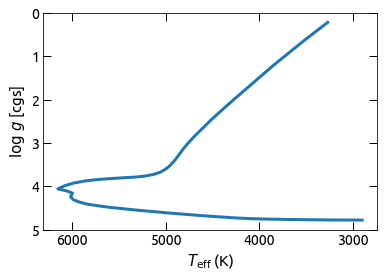

In [3]:
import matplotlib.pylab as plt
%matplotlib inline

plt.plot(10**iso['logt'], iso['logg'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('$T_\mathrm{eff}$ (K)')
plt.ylabel('$\log\ g$ [cgs]');

By default, the isochrone grid employed is the Yonsei-Yale one ("yy"), spaced in [Fe/H] intervals of "0.02" dex. This grid is in an SQLite ("sql3") database called "yy02.sql3". To get an isochrone of equal parameters, but from the finely-spaced grid version (0.01 dex steps in [Fe/H]), we use the "yy01.sql3" database instead. We can also grab a solar-age, solar-metallicity isochrone from a finely-spaced Darmouth database ("dm01.sql3") for comparison:

In [4]:
iso_yy = q2.isopars.get_isochrone(age=4.5, feh=0, db='yy01.sql3')
iso_dm = q2.isopars.get_isochrone(age=4.5, feh=0, db='dm01.sql3')

Now, let's see them on the H-R diagram:

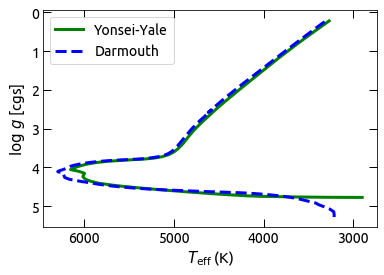

In [5]:
plt.plot(10**iso_yy['logt'], iso_yy['logg'], label='Yonsei-Yale', color='green')
plt.plot(10**iso_dm['logt'], iso_dm['logg'], '--', label='Darmouth', color='blue')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('$T_\mathrm{eff}$ (K)')
plt.ylabel('$\log\ g$ [cgs]')

plt.legend(loc='best', fontsize=14);

### Finding parameters for one star

It is possible to determine stellar parameters like mass and age by comparing the location of stars in stellar parameter space with those of a given set of isochrones. The "location" of a star is of course never known with infinite precision. Thus, to derive isochrone parameters, a star object must have its stellar parameters *and* errors defined, even if they are very small. Let's try creating a sun star object with tiny error bars:

In [6]:
sun = q2.Star('Sun', teff=5777, logg=4.437, feh=0.0)
sun.err_teff = 5
sun.err_logg = 0.01
sun.err_feh = 0.005

The isopars.solve_one function takes a star object and performs a maximum-likelihood calculation to determine which mass, age, etc., values are the most probable ("m.p."). It also calculates 1-$\sigma$-like and 2-$\sigma$-like ranges for these parameters, as well as simple mean and standard deviation values of all isochrone points that fell inside the star's location box.

In the example below, we first define SolvePars (required) and PlotPars (optional) controllers. Use the former to specify the isochrone database to employ (Yonsei-Yale, 0.01 dex [Fe/H] spacing in this case) and the 'key_parameter_known', which can be either the parallax ('plx', the default) or a $\log\,g$ value ('logg'), determined for example spectroscopically. In this case (Sun), we do not have a parallax available, so we will use its known $\log\,g$ value instead.

By default, q<sup>2</sup> creates a generic figure with all probability distributions included (\*\_isopar\_\*). Since the age probability distribution is used frequently, you can also create a nicer figure that shows only the age result (\*\_isoage\_\*) by changing the PlotPars.make_age_plot attribute to True:

In [7]:
sp = q2.isopars.SolvePars()
sp.db = 'yy01.sql3'
sp.key_parameter_known = 'logg'

pp = q2.isopars.PlotPars()
pp.make_age_plot = True

q2.isopars.solve_one(sun, sp, pp)

Using 114 isochrone points

Parameter      m.p. |  1-sigma range  |  2-sigma range  |   mean +/-  stdev
----------   ------ | --------------- | --------------- | -----------------
age           4.100 |  3.704 -  4.712 |  3.283 -  5.200 |  4.204 +/-  0.490
mass          1.010 |  1.003 -  1.024 |  1.000 -  1.029 |  1.012 +/-  0.005
logl          0.000 | -0.009 -  0.012 | -0.018 -  0.021 |  0.003 +/-  0.009
mv            4.840 |  4.821 -  4.859 |  4.784 -  4.882 |  4.829 +/-  0.022
r             1.000 |  0.991 -  1.012 |  0.982 -  1.045 |  1.004 +/-  0.009


The relevant results are given in this table, in particular the most probable values. In some cases, q<sup>2</sup> will not be able to do the statistics properly and an m.p. value will not be shown. However, it might still be able to provide a simple mean and stdev of the input isochrone points, which could be useful. In other cases, q<sup>2</sup> will be able to solve for some, but not all parameters. In this case, the calculation was fully successful.

The output figures are not shown on the notebook by default, but we can always take a look at, for example the age probability distribution plot (a PNG image) as follows:

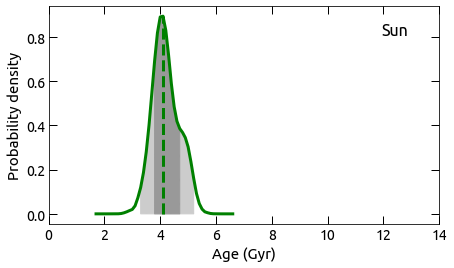

In [8]:
from IPython.display import Image
Image(filename='Sun_isoage_logg.png')

Notice that this is a very smooth distribution even though the original probability distribution plot is quite spiky, as shown in the generic figure (top panel):

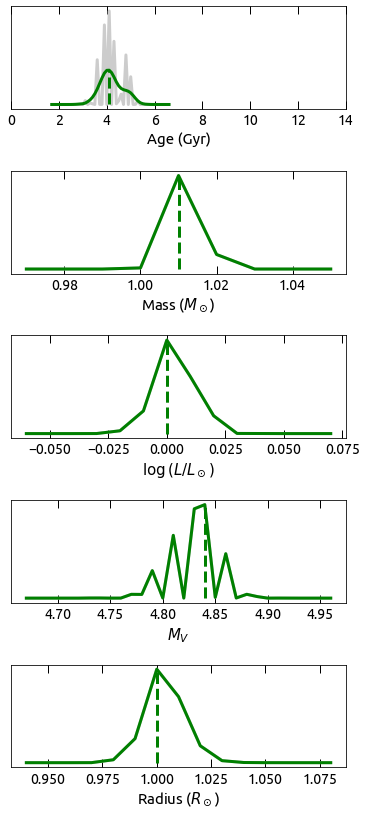

In [9]:
Image(filename='Sun_isopar_logg.png')

Smoothing is controlled by SolvePars. By default, SolvePars.smooth_window_len_age = 13, but this can be changed to shorter or longer windows for less or more smoothing, respectively. One can also smooth the mass, log L, etc. distributions by setting their corresponding smoothing windows lengths (none of these are smoothed out by default).

The figures we have generated so far in this part of the Tutorial are in PNG format, but as we saw before, they could be changed to, for example PDF by using the figure_format attribute of PlotPars. In addition, we can change the limits of the x-axis in the age figure, as well as the title inside the box, as long as we are requesting the age figure (make_age_plot = True).

Note that the age derived above for the Sun is a bit young (the Sun's age is 4.6 Gyr), while the mass is 1% over the actual solar mass. This is an inevitable limitation of the isochrones. One way to address this problem is to shift the [Fe/H] values of the isochrones by a certain amount. For Yonsei-Yale isochrones, for example, an offset of -0.04 dex produces better solar age and mass values (but note that the absolute magnitude is now farther from the accepted value of 4.83):

In [10]:
pp = q2.isopars.PlotPars()
pp.figure_format = 'pdf'
pp.make_age_plot = True
pp.age_xlim = [2.5, 7]
pp.title_inside = 'Sun, Y$^2$'

sp.feh_offset = -0.04
q2.isopars.solve_one(sun, sp, pp)

from IPython.display import IFrame
IFrame('Sun_isoage_logg.pdf', width=600, height=400)

Using 113 isochrone points

Parameter      m.p. |  1-sigma range  |  2-sigma range  |   mean +/-  stdev
----------   ------ | --------------- | --------------- | -----------------
age           4.600 |  4.134 -  5.108 |  3.581 -  5.510 |  4.627 +/-  0.481
mass          1.000 |  0.992 -  1.014 |  0.985 -  1.019 |  1.000 +/-  0.005
logl          0.010 | -0.007 -  0.024 | -0.019 -  0.029 | -0.001 +/-  0.009
mv            4.850 |  4.822 -  4.874 |  4.806 -  4.924 |  4.835 +/-  0.018
r             1.000 |  0.990 -  1.012 |  0.980 -  1.028 |  1.000 +/-  0.010


In the previous examples we used surface gravity as an input parameter. When $\log\,g$ can be measured accurately, using it as a luminosity indicator is a reasonable approach. Very often, however, a known trigonometric parallax allows us to determine a star's absolute magnitude, which in some cases may be more reliable than $\log\,g$ as a luminosity index.

In the following lines, we are going to use isopars to determine stellar parameters for the star iota Horologii (iotaHor), which has a known photometric $T_\mathrm{eff}=6163\pm80$ K and [Fe/H]$=0.15\pm0.05$. Its measured trigonometric parallax is $58.25\pm0.22$ mas and its apparent magnitude is $V=5.40\pm0.02$:

In [11]:
s = q2.Star('iotaHor')
s.teff, s.err_teff = 6263, 80
s.feh, s.err_feh = 0.15, 0.05
s.plx, s.err_plx = 58.25, 0.22
s.v, s.err_v = 5.40, 0.02

We are going to apply the -0.04 dex offset to the [Fe/H] of the isochrones to "normalize" the results to the solar values. Then, we are also going to smooth the mass and $\log\,g$ probability distributions. We are not passing a PlotPars controller here so we are not going to request the separate age probability figure. It turns out that iotaHor is a young star so its isochrone age is uncertain anyway. However, other parameters such as mass and $\log\,g$ can be estimated accurately:

Using 2165 isochrone points

Parameter      m.p. |  1-sigma range  |  2-sigma range  |   mean +/-  stdev
----------   ------ | --------------- | --------------- | -----------------
age           1.000 |  0.502 -  1.829 |  0.156 -  2.822 |  1.254 +/-  0.690
mass          1.190 |  1.164 -  1.209 |  1.138 -  1.231 |  1.184 +/-  0.022
logl          0.220 |  0.208 -  0.248 |  0.197 -  0.245 |  0.223 +/-  0.010
mv            4.210 |  4.195 -  4.245 |  4.174 -  4.270 |  4.223 +/-  0.024
r             1.140 |  1.123 -  1.158 |  1.108 -  1.184 |  1.141 +/-  0.018
logg          4.400 |  4.376 -  4.418 |  4.347 -  4.434 |  4.396 +/-  0.021


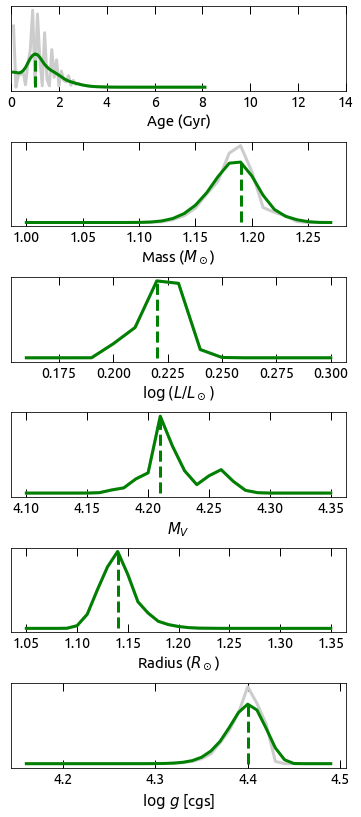

In [12]:
sp = q2.isopars.SolvePars()
sp.feh_offset = -0.04
sp.smooth_window_len_mass = 7
sp.smooth_window_len_logg = 7

q2.isopars.solve_one(s, sp)

Image(filename='iotaHor_isopar_plx.png')

While the isochrone age of this star is very uncertain (all we can say is that it is younger than about 2 Gyr), its mass is very well constrained to about $1.19\pm0.02\,M_\odot$, as is its $\log\,g=4.40\pm0.02$. Smoothing the distributions can provide more accurate results as they are sometimes too spiky and finding the most probable value (the highest peak) might produce biased results.

Note that the figure generated in the latter case has the format \*\_plx.png. This is because the key_parameter_known was set to plx. Otherwise the figure format is \*\_logg.png.

### Working with a sample

The examples above show how to use q<sup>2</sup> to analyze one star at a time. If you need to analyze a sample instead, you should use the isopars.solve_all function, which takes as input an entire q2.Data object. Both SolvePars and PlotPars controllers are required in this case, as well as an output file name where the results will be recorded.

In the following example, we use isopars.solve_all to find isochrone stellar parameters for a sample of solar twin stars which all have parallaxes measured by Hipparcos (columns plx, err_plx in file 'stps_hipparcos.csv'). We are going to apply the $-0.04$ dex offset to the isochrone [Fe/H] values, use the finely-spaced Yonsei-Yale isochrone database ('yy01.sql3'), and smooth-out the logg distributions. Figures will be saved into a directory called stps_hipparcos. Since we know that these are all Galactic disk stars, we will restrict the age axis of the age plots to 0-9 Gyr. Both the generic and age plots will be generated.

In [13]:
d = q2.Data('stps_hipparcos.csv')

sp = q2.isopars.SolvePars()
sp.db = 'yy01.sql3'
sp.feh_offset = -0.04
sp.smooth_window_len_logg = 7

pp = q2.isopars.PlotPars()
pp.make_age_plot = True
pp.age_xlim = [0, 9]
pp.directory = 'stps_hipparcos'

q2.isopars.solve_all(d, sp, pp, 'stps_hipparcos_isopars_plx.csv')

------------------------------------------------------
Initializing ...
- Date and time: 16-Jul-2017, 17:58:13
- Star data: stps_hipparcos.csv
------------------------------------------------------

********
HIP19911
********
Using 1699 isochrone points

Parameter      m.p. |  1-sigma range  |  2-sigma range  |   mean +/-  stdev
----------   ------ | --------------- | --------------- | -----------------
age           3.900 |  1.782 -  6.066 |  0.729 -  7.725 |  3.849 +/-  1.932
mass          0.990 |  0.973 -  1.004 |  0.961 -  1.019 |  0.989 +/-  0.014
logl         -0.070 | -0.087 - -0.017 | -0.099 -  0.039 | -0.037 +/-  0.038
mv            5.060 |  4.896 -  5.071 |  4.738 -  5.121 |  4.937 +/-  0.096
r             0.930 |  0.912 -  0.986 |  0.901 -  1.062 |  0.962 +/-  0.042
logg          4.500 |  4.437 -  4.521 |  4.371 -  4.539 |  4.466 +/-  0.044

********
HIP44713
********
Using 98 isochrone points

Parameter      m.p. |  1-sigma range  |  2-sigma range  |   mean +/-  stdev
------

If you'd rather employ the very precise $\log\,g$ values of your stars and ignore the parallax information, set the key_parameter_known to 'logg'. Since the solutions will now be different, we will use a different filename for the output. Figures will be sent to the same directory as before because we will pass the same PlotPars controller ('pp'). You will notice that the figure filenames are different this time, so sending them to that same directory will not be an issue:

In [14]:
sp.key_parameter_known = 'logg'

q2.isopars.solve_all(d, sp, pp, 'stps_hipparcos_isopars_logg.csv')

------------------------------------------------------
Initializing ...
- Date and time: 16-Jul-2017, 17:59:44
- Star data: stps_hipparcos.csv
------------------------------------------------------

********
HIP19911
********
Using 1283 isochrone points

Parameter      m.p. |  1-sigma range  |  2-sigma range  |   mean +/-  stdev
----------   ------ | --------------- | --------------- | -----------------
age           4.000 |  2.424 -  5.511 |  1.022 -  6.776 |  3.996 +/-  1.465
mass          0.990 |  0.975 -  1.002 |  0.962 -  1.010 |  0.987 +/-  0.012
logl         -0.030 | -0.063 - -0.008 | -0.087 -  0.030 | -0.036 +/-  0.026
mv            4.940 |  4.872 -  5.011 |  4.794 -  5.062 |  4.933 +/-  0.067
r             0.970 |  0.935 -  0.994 |  0.912 -  1.028 |  0.964 +/-  0.028

********
HIP44713
********
Using 91 isochrone points

Parameter      m.p. |  1-sigma range  |  2-sigma range  |   mean +/-  stdev
----------   ------ | --------------- | --------------- | -----------------
age   

Let's compare the age probability distributions of HIP 72043, as determined by the parallax and $\log\,g$, respectively:

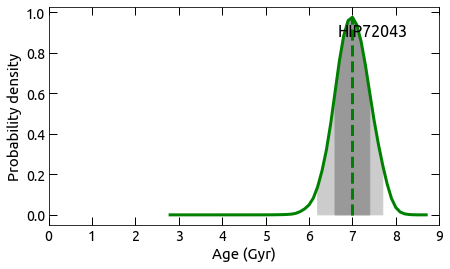

In [15]:
Image(filename='stps_hipparcos/HIP72043_isoage_plx.png')

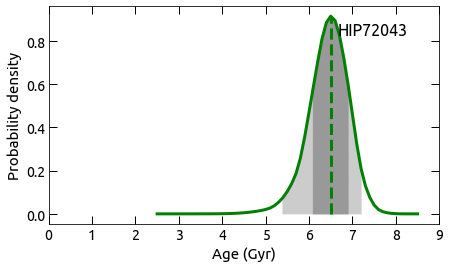

In [16]:
Image(filename='stps_hipparcos/HIP72043_isoage_logg.png')

They are clearly very similar to each other, but not identical. Isochrone stellar parameters are highly model dependent as well as input dependent. It is up to the user to decide what is the best combination of input parameters and models to use. q<sup>2</sup> is relatively flexible with regards to this. The Yonsei-Yale and Darmouth isochrones are included in the q<sup>2</sup> Data file. Any other isochrone set could in principle be adapted by creating a SQLite3 database in the same format.

_Note: q<sup>2</sup> uses a frequentist approach to determine stellar parameters from isochrones. This approach is known to have severe limitations, which are alleviated by using Bayesian techniques instead. Users are encouraged to try the [isochrones Python package](http://isochrones.readthedocs.org/en/latest/) if a more comprehensive analysis is required._

## The End

This concludes the q<sup>2</sup> Tutorial. If you have any questions or requests, please e-mail <iramirez@tacomacc.edu>. Happy q<sup>2</sup>-ing!